# EDA - AffWild2

- All cropped-aligned images have the same dimensions: 112 x 112 x 3.
- EXPR_Classification_Challenge:
  - Each annotation file is named after the video
that it corresponds to.
  - The first line of each annotation file is always:
Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise,Other
  - Each line thereafter shows one annotation value in: {0,1,2,3,4,5,6,7}; these values correspond
to the emotions: {Neutral,Anger,Disgust,Fear,Happiness,Sadness,Surprise,Other}. Each value
corresponds to each videoframe, i.e., the first value corresponds to the first videoframe, the
second one corresponds to the second videoframe and so on.
  - For some frames, the annotation value can be -1; such frames should be disregarded.


  0: Neutral
  1: Anger
  2: Disguts
  3: Fear
  4: Happiness
  5: Sadness
  6: Surprise
  7: Other

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## Libraries

In [ ]:
import os
import cv2
import csv
import math
import keras

import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from imutils import paths
from IPython.display import Image

from moviepy.editor import *

## Functions

In [ ]:
def split_video_into_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    # Lee y guarda cada frame
    success, frame = cap.read()
    count = 0
    frames = []

    while success:
        frames.append(frame)
        success, frame = cap.read()
        count += 1

    cap.release()

    return frames

In [ ]:
labels_expressions_map = {
    0: "Neutral",
    1: "Anger",
    2: "Disgust",
    3: "Fear",
    4: "Happiness",
    5: "Sadness",
    6: "Surprise",
    7: "Other",
    -1: "Skip"
}

def get_labels_for_single_file(filepath):
    df = pd.DataFrame(columns=["labels", "labels_expression"])
    with open(filepath) as _file:
        lines = _file.read().splitlines()[1:]
        df["labels"] = lines

    df["labels_expression"] = df["labels"]
    df["labels_expression"] = df["labels_expression"].replace(labels_expressions_map)

    return df

In [ ]:
def get_file_name_from_path(path):
    splitted_path = path.split("/")
    if len(splitted_path) == 0:
        return ""

    last_path = splitted_path[-1]
    last_path_splitted = last_path.split(".")
    if len(last_path_splitted) == 0:
        return last_path

    return last_path_splitted[0]

In [ ]:
def count_frames(video_path_without_extension):

    video_path = video_path_without_extension + ".mp4"

    if not os.path.exists(video_path):
        video_path = video_path_without_extension + ".avi"

    print("Looking for: " + video_path)
    # Abre el video
    cap = cv2.VideoCapture(video_path)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print("Error opening video " + video_path)
        return

    # Inicializa el contador de frames
    frame_count = 0

    # Lee el video frame por frame y cuenta los frames
    while True:
        ret, _ = cap.read()

        # Si no hay más frames, sal del bucle
        if not ret:
            break

        # Incrementa el contador de frames
        frame_count += 1

    # Cierra el video
    cap.release()

    return frame_count

In [ ]:
def get_label_frames(filepath):
    df = pd.read_csv(filepath)

    return len(df)

In [ ]:
def create_empty_csv():
    columns = ['Name', 'Label_frames', 'Video_frames']
    with open(CSV_PATH, 'w', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=columns)
        writer.writeheader()

In [ ]:
def add_row_to_csv(name, label_frames, video_frames):
    columns = ['Name', 'Label_frames', 'Video_frames']
    row_to_add = {'Name': name, 'Label_frames': label_frames, 'Video_frames': video_frames}
    with open(CSV_PATH, 'a', newline='') as csv_file:
        writer = csv.DictWriter(csv_file, fieldnames=columns)
        writer.writerow(row_to_add)

In [ ]:
def get_file_names(path):
    file_names_full = os.listdir(path)
    file_names = []

    for file_name in file_names_full:
        base_name, extension = os.path.splitext(file_name)
        file_names.append({"Name": base_name, "Extension": extension})

    return file_names

In [ ]:
def compare_frames(file_names):
    for file_name in file_names:
        video_frames = count_frames(AFF_WILD2_VIDEOS_PATH + file_name["Name"])

        label_frames = get_label_frames(AFF_WILD2_LABELS_PATH + file_name["Name"] + ".txt")

        add_row_to_csv(file_name, label_frames, video_frames)

In [ ]:
def get_duration_and_frame_count_from_video(filename):
    import subprocess, json

    result = subprocess.check_output(
            f'ffprobe -v quiet -show_streams -select_streams v:0 -of json "{filename}"',
            shell=True).decode()
    fields = json.loads(result)['streams'][0]

    duration = fields['duration']
    frames = fields['nb_frames']
    return float(duration), float(frames)

In [ ]:
def get_video_frames_in_n_fps(file_name, n_fps):
    duration, _ = get_duration_and_frame_count_from_video(file_name)
    return math.ceil(duration / n_fps)

## Paths

In [ ]:
DATASETS_PATH = "/content/drive/MyDrive/TPP/TPP - sisop?/Datasets/"
AFF_WILD2_PATH = DATASETS_PATH + "Aff-Wild2/"
AFF_WILD2_VIDEOS_PATH = AFF_WILD2_PATH + "raw-videos/"
AFF_WILD2_LABELS_PATH = AFF_WILD2_PATH + "Annotations/EXPR_Classification_Challenge/"
AFF_WILD2_DATAFRAMES_PATH = AFF_WILD2_PATH + "dataframes/"

CSV_PATH = AFF_WILD2_PATH + "frames_comparison.csv"

## Videos match with labels? And amount of frames per video ✅

In [ ]:
# be careful, this will erase csv already calculated!
# create_empty_csv()

In [ ]:
file_names = get_file_names(AFF_WILD2_LABELS_PATH)
len(file_names)

317

In [ ]:
video_file_names = get_file_names(AFF_WILD2_VIDEOS_PATH)
video_file_names

[{'Name': 'video69', 'Extension': '.mp4'},
 {'Name': 'video27', 'Extension': '.mp4'},
 {'Name': '9-15-1920x1080', 'Extension': '.mp4'},
 {'Name': '7-60-1920x1080', 'Extension': '.mp4'},
 {'Name': 'video74', 'Extension': '.mp4'},
 {'Name': '35-30-1920x1080', 'Extension': '.mp4'},
 {'Name': '123-25-1920x1080', 'Extension': '.mp4'},
 {'Name': '1-30-1280x720', 'Extension': '.mp4'},
 {'Name': '10-60-1280x720', 'Extension': '.mp4'},
 {'Name': '100-29-1080x1920', 'Extension': '.mp4'},
 {'Name': '101-30-1080x1920', 'Extension': '.mp4'},
 {'Name': '102-30-640x360', 'Extension': '.mp4'},
 {'Name': '102', 'Extension': '.avi'},
 {'Name': '103-30-384x480', 'Extension': '.mp4'},
 {'Name': '105-30-1280x720', 'Extension': '.mp4'},
 {'Name': '105', 'Extension': '.avi'},
 {'Name': '106-30-720x1280', 'Extension': '.mp4'},
 {'Name': '106', 'Extension': '.avi'},
 {'Name': '107-30-640x480', 'Extension': '.mp4'},
 {'Name': '107', 'Extension': '.avi'},
 {'Name': '108-15-640x480', 'Extension': '.mp4'},
 {'Name

In [ ]:
compare_frames(video_file_names)

Looking for: /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/Aff-Wild2/raw-videos/389.mp4
Looking for: /content/drive/MyDrive/TPP/TPP - sisop?/Datasets/Aff-Wild2/raw-videos/9-15-1920x1080.mp4


KeyboardInterrupt: 

We ran a local notebook to generate a CSV file with the video name and the frames count based on the video and based on the labels files.

In [ ]:
frames_comparison_df = pd.read_csv(AFF_WILD2_PATH + "frames_comparison.csv")

In [ ]:
file_names_with_extensions_df = pd.DataFrame(video_file_names)
file_names_with_extensions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Name       598 non-null    object
 1   Extension  598 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [ ]:
frames_comparison_df = frames_comparison_df.merge(file_names_with_extensions_df, how="left", on="Name")
frames_comparison_df.rename(columns={"Extension": "Video_extension"}, inplace=True)
frames_comparison_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318 entries, 0 to 317
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             318 non-null    object 
 1   Label_frames     318 non-null    int64  
 2   Video_frames     309 non-null    float64
 3   Video_extension  308 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 12.4+ KB


The 9 rows difference is because there were some txt files that didn't have a matching video. Usually the names contained "right" or "left"

In [ ]:
frames_comparison_df = frames_comparison_df.dropna()
frames_comparison_df["Video_frames"] = frames_comparison_df['Video_frames'].astype(int)

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frames_comparison_df["Video_frames"] = frames_comparison_df['Video_frames'].astype(int)



In [ ]:
frames_comparison_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 0 to 316
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             308 non-null    object
 1   Label_frames     308 non-null    int64 
 2   Video_frames     308 non-null    int64 
 3   Video_extension  308 non-null    object
dtypes: int64(2), object(2)
memory usage: 12.0+ KB


In [ ]:
frames_comparison_df["Frames_delta"] = frames_comparison_df["Label_frames"] - frames_comparison_df["Video_frames"]

In [ ]:
frames_comparison_df["Frames_delta"].value_counts()

 1    199
 0     94
 2      9
-1      6
Name: Frames_delta, dtype: int64

Vamos a ver algunos ejemplos de estos casos, para usarlos como evidencia

In [ ]:
two_rows = frames_comparison_df[frames_comparison_df["Frames_delta"] == 2]["Name"].sample(5).tolist()
two_rows

['112', '135', '207', '119', '106']

In [ ]:
one_rows = frames_comparison_df[frames_comparison_df["Frames_delta"] == 1]["Name"].sample(5).tolist()
one_rows

['424',
 '32-60-1920x1080',
 '99-30-720x720',
 '45-24-1280x720',
 '124-30-720x1280']

In [ ]:
negative_one_rows = frames_comparison_df[frames_comparison_df["Frames_delta"] == -1]["Name"].sample(5).tolist()
negative_one_rows

['348', '339', '327', '377', '447']

## % of useful dataset ✅
Now we will check what is the proportion of videos that are tagged in the format we need (i.e. with the 7 emotions)

In [ ]:
videos = os.listdir(AFF_WILD2_VIDEOS_PATH)
labels = os.listdir(AFF_WILD2_LABELS_PATH)

f"We got {len(videos)} videos and {len(labels)} properly tagged"

'We got 598 videos and 317 properly tagged'

In [ ]:
videos_df = pd.DataFrame(videos, columns=["video_path"])
labels_df = pd.DataFrame(labels, columns=["label_path"])

videos_df.shape, labels_df.shape

((598, 1), (317, 1))

In [ ]:
videos_df["file_name"] = videos_df["video_path"].apply(lambda x: get_file_name_from_path(x))
labels_df["file_name"] = labels_df["label_path"].apply(lambda x: get_file_name_from_path(x))

In [ ]:
videos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_path  598 non-null    object
 1   file_name   598 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


In [ ]:
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label_path  317 non-null    object
 1   file_name   317 non-null    object
dtypes: object(2)
memory usage: 5.1+ KB


In [ ]:
df = videos_df.merge(labels_df, how="outer", on="file_name")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_path  598 non-null    object
 1   file_name   607 non-null    object
 2   label_path  317 non-null    object
dtypes: object(3)
memory usage: 19.0+ KB


In [ ]:
useful_df = df.loc[(df["video_path"].notnull()) & (df["label_path"].notnull())].copy()
useful_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 2 to 595
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   video_path  308 non-null    object
 1   file_name   308 non-null    object
 2   label_path  308 non-null    object
dtypes: object(3)
memory usage: 9.6+ KB


In [ ]:
f"Amount of useful videos are {len(useful_df)}. This represents a {(len(useful_df)/len(df)*100):.2f}% of total"

'Amount of useful videos are 308. This represents a 50.74% of total'

In [ ]:
useful_df.to_csv(AFF_WILD2_DATAFRAMES_PATH + "useful_df.csv", sep=",", encoding="utf-8", index=False)

## Amount of useful frames ✅
Now we will check amount of frames using only useful videos

In [ ]:
frames_comparison_df.rename(columns={"Name": "file_name"}, inplace=True)
frames_comparison_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 0 to 316
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   file_name        308 non-null    object
 1   Label_frames     308 non-null    int64 
 2   Video_frames     308 non-null    int64 
 3   Video_extension  308 non-null    object
 4   Frames_delta     308 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 14.4+ KB


In [ ]:
useful_frames_df = useful_df.merge(frames_comparison_df, how="left", on="file_name")
useful_frames_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 308 entries, 0 to 307
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   video_path       308 non-null    object
 1   file_name        308 non-null    object
 2   label_path       308 non-null    object
 3   Label_frames     308 non-null    int64 
 4   Video_frames     308 non-null    int64 
 5   Video_extension  308 non-null    object
 6   Frames_delta     308 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 19.2+ KB


In [ ]:
mean = useful_frames_df["Video_frames"].mean()
total = useful_frames_df["Video_frames"].sum()

f"Amount of useful frames is {total:.0f}. Average {mean:.2f} per video"

'Amount of useful frames is 1504429. Average 4884.51 per video'

In [ ]:
useful_frames_df["Video_frames"].max()

47434

## Amount of frames per video reducing to 6fps ✅


In [ ]:
N_FPS = 12

useful_frames_df["Video_frames_12fps"] = useful_frames_df.apply(
    lambda row: get_video_frames_in_n_fps(AFF_WILD2_VIDEOS_PATH + row["file_name"] + row["Video_extension"], N_FPS), axis = 1)
useful_frames_df.info()

In [ ]:
mean = useful_frames_df["Video_frames_12fps"].mean()
total = useful_frames_df["Video_frames_12fps"].sum()

f"Amount of useful frames reducing videos to {N_FPS}fps is {total}. Average {mean:.2f} per video"

## Emotions distribution ✅


Now we will study emotions distribution over the videos we will plan to use

In [ ]:
df = useful_df

In [ ]:
labels = df["label_path"].tolist()
len(labels)

308

In [ ]:
labels_df = pd.DataFrame(columns=["file_name", "labels"])
for i, label in enumerate(labels):
    print(f"{i}/{len(labels)} - about to read {label} file")
    this_df = pd.DataFrame()
    with open(AFF_WILD2_LABELS_PATH + label) as _file:
        lines = _file.read().splitlines()[1:]
        this_df["labels"] = lines
        this_df["file_name"] = label
    labels_df = pd.concat([labels_df, this_df], ignore_index=True)
labels_df.info()

0/308 - about to read 9-15-1920x1080.txt file
1/308 - about to read 7-60-1920x1080.txt file
2/308 - about to read 35-30-1920x1080.txt file
3/308 - about to read 123-25-1920x1080.txt file
4/308 - about to read 1-30-1280x720.txt file
5/308 - about to read 10-60-1280x720.txt file
6/308 - about to read 100-29-1080x1920.txt file
7/308 - about to read 101-30-1080x1920.txt file
8/308 - about to read 102-30-640x360.txt file
9/308 - about to read 102.txt file
10/308 - about to read 103-30-384x480.txt file
11/308 - about to read 105-30-1280x720.txt file
12/308 - about to read 105.txt file
13/308 - about to read 106-30-720x1280.txt file
14/308 - about to read 106.txt file
15/308 - about to read 107-30-640x480.txt file
16/308 - about to read 107.txt file
17/308 - about to read 108-15-640x480.txt file
18/308 - about to read 108.txt file
19/308 - about to read 109-30-1280x720.txt file
20/308 - about to read 11-24-1920x1080.txt file
21/308 - about to read 110-30-270x480.txt file
22/308 - about to rea

In [ ]:
labels_df["labels"] = pd.to_numeric(labels_df["labels"], downcast='integer')
labels_df["labels_expression"] = labels_df["labels"]
labels_df["labels_expression"] = labels_df["labels_expression"].replace(labels_expressions_map)
labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504640 entries, 0 to 1504639
Data columns (total 3 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   file_name          1504640 non-null  object
 1   labels             1504640 non-null  int8  
 2   labels_expression  1504640 non-null  object
dtypes: int8(1), object(2)
memory usage: 24.4+ MB


<Axes: >

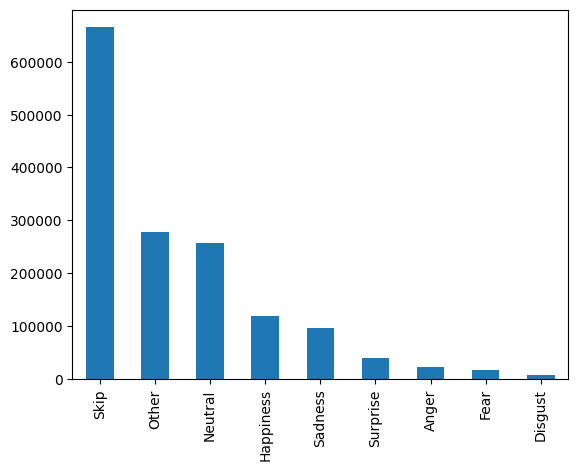

In [ ]:
labels_df["labels_expression"].value_counts().plot(kind="bar")

Vemos que tenemos una gran cantidad de frames que no nos van a servir: `Skip` y `Other`. A ver qué pasa sin ellos

In [ ]:
useful_labels_df = labels_df.loc[~labels_df["labels_expression"].isin(["Skip", "Other"])]
useful_labels_df.shape

(561338, 3)

In [ ]:
f"Amount of useful labels are {len(useful_labels_df)} and this represents a {(len(useful_labels_df)/len(labels_df)*100):.2f}% of total"

'Amount of useful labels are 561338 and this represents a 37.31% of total'

<Axes: >

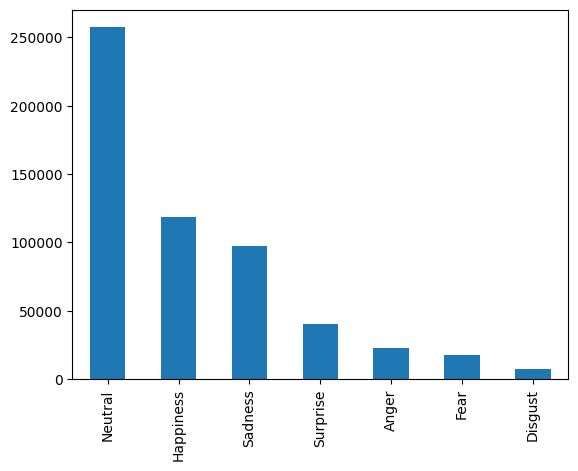

In [ ]:
useful_labels_df["labels_expression"].value_counts().plot(kind="bar")

## How much fps has our videos

In [ ]:
scene = AFF_WILD2_VIDEOS_PATH + "118.avi"
clip = VideoFileClip(scene)

In [ ]:
vid = cv2.VideoCapture(scene)
height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = vid.get(cv2.CAP_PROP_FRAME_WIDTH)

print (height)
print (width)

360.0
640.0


In [ ]:
fps = vid.get(cv2.CAP_PROP_FPS)

print(fps)

29.97002997002997
